Notebook for data augmentation of real car images. Goals:
* Generate more real images using GAN (or VAE)
* Augment all the training images (and testing?) by adding backgrounds
* Augment by transforming the images (rotate, ...)

In [12]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/02456 Deep learning/Final project/')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/02456 Deep learning/Final project'

In [13]:
## Imports

%matplotlib inline
import os
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

from PIL import Image

In [14]:
## Set up

# Paths
data_path_arrays = 'carseg_data/arrays'

# Class label map color (assume class labels have been mapped to 0-9)
class_to_color = {
    0: (255, 255, 255),  # White (Background)
    1: (255, 165, 0),  # Orange (Hood)
    2: (0, 128, 0),    # Dark Green (Front door)
    3: (255, 255, 0),  # Yellow (Rear door)
    4: (0, 255, 255),  # Cyan (Frame)
    5: (128, 0, 128),  # Purple (Rear quarter panel)
    6: (144, 238, 144),  # Light Green (Trunk lid)
    7: (0, 0, 255),    # Blue (Fender)
    8: (255, 192, 203),  # Pink (Bumper)
    9: (0, 0, 0)      # Black (Rest of the car)
}

In [15]:
## Utlilities

def plot_image(image):
    # Plots a single image on rgb 0-255 scale
    if torch.is_tensor(image):
        image = image.detach().cpu().permute((1, 2, 0)).numpy()
    with sns.axes_style("white"):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.show()


def segment_image(image, labels):
    # Segments an image based on class labels using color map
    # Returns segmented image as tensor
    if torch.is_tensor(image):
        # Convert tensor to numpy arrays
        image = image.detach().cpu().permute(1, 2, 0).numpy()
        labels = labels.detach().cpu().numpy()

    segmented_image = np.zeros_like(image)

    # Color the pixels based on the class values
    # Excluding class 0 and class 90 if want to include background and rest of the car
    for class_value, color in class_to_color.items():
        #if class_value != 0 and class_value != 90:
        segmented_image[labels == class_value] = color

    # If want to include background and rest of the car
    # segmented_image[label == 0] = image[label == 0]
    # segmented_image[label == 90] = image[label == 90]

    # Convert to tensor
    segmented_image = torch.from_numpy(segmented_image).permute(2, 0, 1).long()

    return segmented_image

def plot_grid_segmented_images(images, labels):
    # Plots a grid of segmented images (tensors)
    segmented_images = []
    for image, label in zip(images, labels):
        segmented_image = segment_image(image, label)
        segmented_images.append(segmented_image)

    plot_image(torchvision.utils.make_grid(segmented_images, nrow=4))

In [16]:
## Segmented image data

test_idx = np.arange(1,31)
test_ids = [f"photo_00{i:02d}.npy" for i in test_idx]

real_photo_pattern = re.compile(r'.*photo.*')

class SegmentedImageDataset(TensorDataset):
    def __init__(self, data_folder_arrays, train, transform=None):
        self.data_folder = data_folder_arrays
        self.data_files = os.listdir(data_folder_arrays)
        self.train = train
        self.transform = transform
        if self.train:
            # Exclude the test filenames to create the training dataset
            self.data_files = [file for file in self.data_files if file not in test_ids]
        else:
            # Include only the test filenames for the test dataset
            self.data_files = [file for file in self.data_files if file in test_ids]

        # Filter real photos of cars
        self.data_files = [file for file in self.data_files if real_photo_pattern.match(file)]

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        file_name = os.path.join(self.data_folder, self.data_files[idx])
        image_data = np.load(file_name)
        image = image_data[:,:,:3]
        image = (image - np.min(image)) / (np.max(image) - np.min(image))   # min-max normalization for the image
        class_labels = image_data[:,:,3]/10   # map class labels to 0-9
        if self.transform:
            image = self.transform(image)
        return torch.from_numpy(image).permute(2, 0, 1).float(), torch.tensor(class_labels).long()


batch_size = 8
num_workers = 0

train_dataset = SegmentedImageDataset(data_folder_arrays=data_path_arrays, train=True)
test_dataset = SegmentedImageDataset(data_folder_arrays=data_path_arrays, train=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

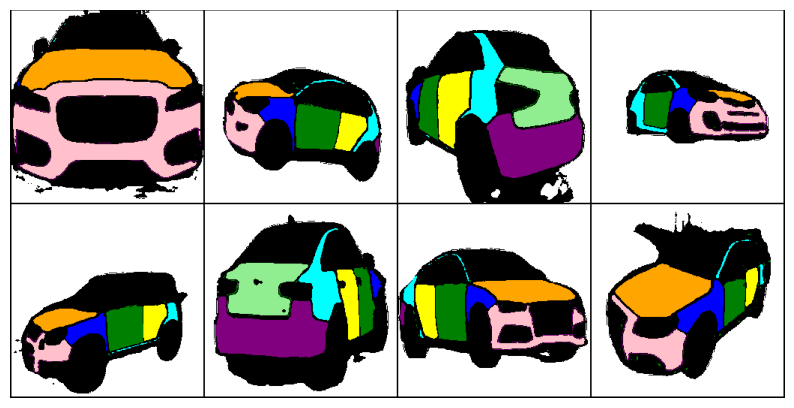

In [17]:
images, labels = next(iter(train_dataloader))
plot_grid_segmented_images(images, labels)

## GAN - based on `7.3-generative-adversarial-networks.ipynb`

In [43]:
#noise_dim = 100  # Assuming a noise vector of size 100

num_classes = 10

nc = 3
nz = 10
ngf = 16
ndf = 16 

# Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.image_branch = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 2 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 8, 4, 2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 8, 4, 2, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, ngf // 2, 8, 4, 2, bias=False),
            nn.BatchNorm2d(ngf // 2),
            nn.ReLU(True),
            # state size. (ngf//2) x 32 x 32
            nn.ConvTranspose2d(ngf // 2, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 256 x 256
        )

        self.mask_branch = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 2 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 8, 4, 2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 8, 4, 2, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, ngf // 2, 8, 4, 2, bias=False),
            nn.BatchNorm2d(ngf // 2),
            nn.ReLU(True),
            # state size. (ngf//2) x 32 x 32
            nn.ConvTranspose2d(ngf // 2, num_classes, 4, 2, 1, bias=False),
            # state size. (nc) x 256 x 256
            nn.Tanh()
        )

    def forward(self, noise):
        image = self.image_branch(noise)
        mask = self.mask_branch(noise)
        return image, mask

# Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.convolutional_branch = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc+1, ndf, 8, 4, 2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 8, 4, 2, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Flatten(),
            #nn.Linear(2*524288,1),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, image, mask):
        img_mask_pair = torch.cat((image, mask), 1)
        x = self.convolutional_branch(img_mask_pair)
        return x



In [19]:
from torchsummary import summary

torch.cuda.empty_cache()

# Assuming you have initialized your generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Move the models to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
generator.to(device)
discriminator.to(device)

# Print the summary for the generator
summary(generator, (nz, 1, 1))  # Assuming your input noise is of size 100

# Print the summary for the discriminator
summary(discriminator, [(3, 256, 256), (1, 256, 256)])  # Assuming your images are of size (3, 256, 256) and masks are (1, 256, 256)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 64, 2, 2]          10,240
       BatchNorm2d-2             [-1, 64, 2, 2]             128
              ReLU-3             [-1, 64, 2, 2]               0
   ConvTranspose2d-4             [-1, 32, 8, 8]         131,072
       BatchNorm2d-5             [-1, 32, 8, 8]              64
              ReLU-6             [-1, 32, 8, 8]               0
   ConvTranspose2d-7           [-1, 16, 32, 32]          32,768
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
  ConvTranspose2d-10          [-1, 8, 128, 128]           8,192
      BatchNorm2d-11          [-1, 8, 128, 128]              16
             ReLU-12          [-1, 8, 128, 128]               0
  ConvTranspose2d-13          [-1, 3, 256, 256]             384
          Sigmoid-14          [-1, 3, 2

In [ ]:
image,mask = generator(torch.randn(2, nz, 1, 1, device=device))
print("Image shape:", image.size())
print(f"Image logits:\n{image.detach().cpu().numpy()}")
print(f"Image probabilities:\n{image.softmax(1).detach().cpu().numpy()}")
print("Mask shape:", mask.size())
print(f"Mask logits:\n{mask.detach().cpu().numpy()}")
print(f"Mask probabilities:\n{mask.softmax(1).detach().cpu().numpy()}")
mask = (mask + 1) * 4.5  # Scale to [0, 9]
mask = torch.round(mask).clamp(0, 9)  # Round and clamp to [0, 9]
print(f"Mask:\n{mask.detach().cpu().numpy()}")

Image shape: torch.Size([2, 3, 256, 256])
Image logits:
[[[[0.48641208 0.4803411  0.5164404  ... 0.4812685  0.4939311
    0.4876372 ]
   [0.48465908 0.49323502 0.5073733  ... 0.5582427  0.5292439
    0.53512686]
   [0.47652826 0.5337948  0.49161145 ... 0.46949995 0.49434748
    0.4787756 ]
   ...
   [0.5010355  0.5207988  0.539959   ... 0.57736665 0.45438516
    0.5309674 ]
   [0.49678293 0.50866026 0.50709176 ... 0.49247268 0.53607756
    0.49420995]
   [0.53334516 0.52010274 0.50927424 ... 0.52705115 0.52901477
    0.5235672 ]]

  [[0.5189388  0.48135298 0.44504046 ... 0.5080412  0.49341148
    0.4759785 ]
   [0.4760797  0.5168021  0.53443015 ... 0.4954111  0.50892794
    0.50168556]
   [0.45816264 0.4439092  0.46727163 ... 0.42609802 0.45848143
    0.4698157 ]
   ...
   [0.4933332  0.4505496  0.5775595  ... 0.4703726  0.5142084
    0.5048561 ]
   [0.4541673  0.47347757 0.48663443 ... 0.44430324 0.43098563
    0.45692006]
   [0.48542926 0.46305853 0.52879304 ... 0.46642563 0.5402325


In [44]:
criterion_image = nn.MSELoss()
criterion_mask = nn.CrossEntropyLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

generator = Generator()
discriminator = Discriminator()
generator.to(device)
discriminator.to(device)

iteration = 0
total_iterations = math.ceil(len(train_dataloader.dataset)/batch_size)*num_epochs
for epoch in range(num_epochs):
    for image,mask in train_dataloader:
        batch_size = image.size(0)
        iteration += 1

        # Generate random noise vector for the generator input
        noise = torch.randn(batch_size, nz, 1, 1)

        # Move data to device
        image, mask = image.to(device), mask.to(device)
        noise = noise.to(device)

        # Convert integer mask labels to one-hot encoded tensors
        mask_one_hot = F.one_hot(mask.squeeze(dim=1).long(), num_classes=num_classes).permute(0,3,2,1).float()
        #print(mask_one_hot.shape)


        # Train discriminator
        optimizer_D.zero_grad()
        generated_image, generated_mask_logits = generator(noise)
        # Apply softmax to the generator's mask output
        generated_mask_probs = F.softmax(generated_mask_logits, dim=1)
        # generated_mask = (generated_mask + 1) * 4.5  # Scale to [0, 9]
        # generated_mask = torch.round(generated_mask).clamp(0, 9)  # Round and clamp to [0, 9]
        # print(generated_mask_logits.shape)
        # print(generated_mask_logits.argmax(dim=1, keepdim=True).shape)
        #print(mask.shape)
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        loss_D_real = criterion_image(discriminator(image, mask.unsqueeze(1)).squeeze(dim=(1,2)), real_labels)
        loss_D_fake = criterion_image(discriminator(generated_image, generated_mask_logits.argmax(dim=1, keepdim=True)).squeeze(dim=(1,2)), fake_labels)
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward(retain_graph=True)
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()
        loss_G_image = criterion_image(discriminator(generated_image, generated_mask_logits.argmax(dim=1, keepdim=True)).squeeze(dim=(1,2)), real_labels)
        #print(generated_mask_logits.argmax(dim=1, keepdim=True).shape)
        #print(mask.squeeze(dim=1).long().shape)
        # print(generated_mask_logits.argmax(dim=1, keepdim=True).shape)
        # print(generated_mask_logits.argmax(dim=1, keepdim=True))
        # print(mask.shape)
        # print(mask)
        loss_G_mask = criterion_mask(generated_mask_probs, mask_one_hot)
        loss_G = loss_G_image + loss_G_mask
        loss_G.backward(retain_graph=True)
        optimizer_G.step()

        # Print training stats (optional)
        if (iteration + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Iteration [{iteration + 1}/{total_iterations}], "
                  f"Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}")

# Save the trained models if needed
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

Epoch [6/100], Iteration [100/1800], Loss_D: 0.4143, Loss_G: 2.5773
Epoch [12/100], Iteration [200/1800], Loss_D: 0.3475, Loss_G: 2.6019
Epoch [17/100], Iteration [300/1800], Loss_D: 0.2840, Loss_G: 2.7015
Epoch [23/100], Iteration [400/1800], Loss_D: 0.4291, Loss_G: 2.6239
Epoch [28/100], Iteration [500/1800], Loss_D: 0.3783, Loss_G: 2.5844
Epoch [34/100], Iteration [600/1800], Loss_D: 0.3925, Loss_G: 2.5694
Epoch [39/100], Iteration [700/1800], Loss_D: 0.3604, Loss_G: 2.6148
Epoch [45/100], Iteration [800/1800], Loss_D: 0.3851, Loss_G: 2.5936
Epoch [50/100], Iteration [900/1800], Loss_D: 0.4384, Loss_G: 2.5860
Epoch [56/100], Iteration [1000/1800], Loss_D: 0.3634, Loss_G: 2.6099
Epoch [62/100], Iteration [1100/1800], Loss_D: 0.3741, Loss_G: 2.6231
Epoch [67/100], Iteration [1200/1800], Loss_D: 0.3952, Loss_G: 2.5749


KeyboardInterrupt: ignored

In [45]:
# Generator output

batch_size = 8

# Predict masks with the model
generator.eval()
with torch.no_grad():
    images, masks = generator(torch.randn(batch_size, nz, 1, 1))


In [46]:
masks.shape

torch.Size([8, 10, 256, 256])

In [55]:
mask.shape

torch.Size([8, 256, 256])

In [47]:
masks.argmax(dim=1, keepdim=True).shape

torch.Size([8, 1, 256, 256])

In [48]:
masks.argmax(dim=1, keepdim=True)[0]

tensor([[[4, 9, 4,  ..., 4, 8, 1],
         [7, 3, 0,  ..., 0, 9, 3],
         [4, 4, 8,  ..., 7, 8, 1],
         ...,
         [7, 3, 2,  ..., 3, 0, 3],
         [4, 4, 8,  ..., 4, 8, 4],
         [2, 3, 0,  ..., 0, 6, 3]]])

In [49]:
images[0]

tensor([[[0.5168, 0.5041, 0.5140,  ..., 0.5055, 0.4890, 0.5025],
         [0.4815, 0.4966, 0.4710,  ..., 0.5153, 0.4576, 0.5040],
         [0.5147, 0.5116, 0.4952,  ..., 0.4957, 0.4822, 0.4968],
         ...,
         [0.4949, 0.4988, 0.4883,  ..., 0.5136, 0.4542, 0.5151],
         [0.5079, 0.4938, 0.5083,  ..., 0.4913, 0.4887, 0.5009],
         [0.4990, 0.5184, 0.4877,  ..., 0.5132, 0.4699, 0.5045]],

        [[0.5191, 0.5048, 0.5308,  ..., 0.4911, 0.5102, 0.4970],
         [0.5028, 0.4866, 0.4898,  ..., 0.4824, 0.4846, 0.5009],
         [0.5217, 0.4779, 0.5221,  ..., 0.4891, 0.5583, 0.4963],
         ...,
         [0.4922, 0.5237, 0.4897,  ..., 0.4942, 0.4897, 0.4871],
         [0.5281, 0.4927, 0.5444,  ..., 0.4965, 0.5585, 0.4964],
         [0.4952, 0.4832, 0.4955,  ..., 0.4762, 0.5052, 0.4934]],

        [[0.4852, 0.4986, 0.5137,  ..., 0.5143, 0.5085, 0.5050],
         [0.5027, 0.5099, 0.4880,  ..., 0.5088, 0.5078, 0.5007],
         [0.5087, 0.5022, 0.5078,  ..., 0.5078, 0.5364, 0.

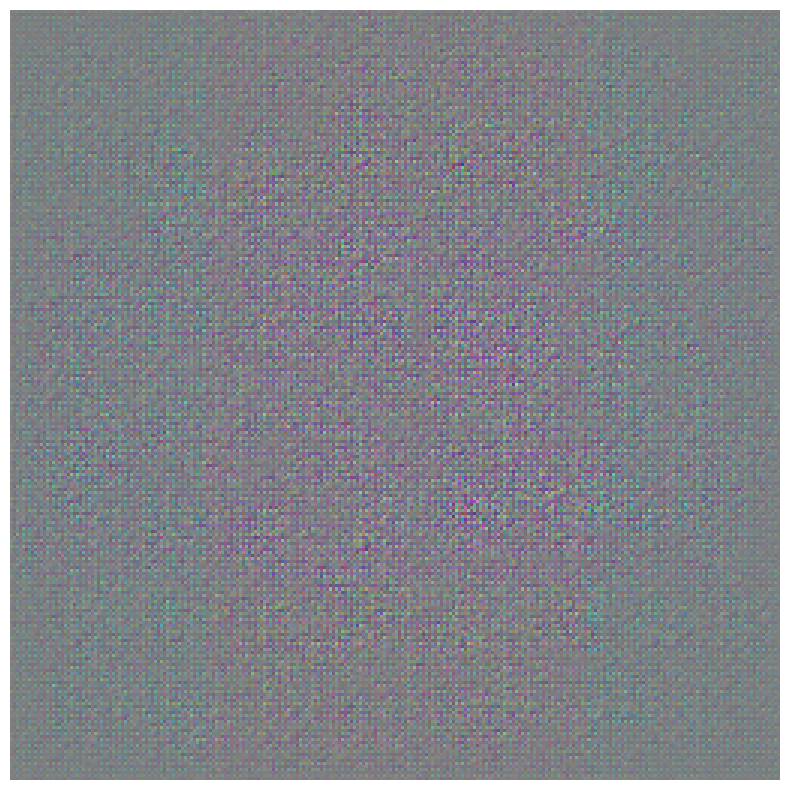

In [50]:
plot_image(images[0])